# Import Libraries

In [1]:
import numpy as np
from numpy import *
from string import *
import pandas as pd
from numpy import *
import random
from string import *
import csv
import time
from pyproj import Proj, transform

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Data Description: [https://www.ncei.noaa.gov/pub/data/igra/data/igra2-data-format.txt](https://www.ncei.noaa.gov/pub/data/igra/data/igra2-data-format.txt)

This is a simple two-balloon flight simulation using a third-order polynomial fit to the coefficient of drag versus altitude. The payload is lifted by two balloons: The parachute balloon and the tractor balloon. The tractor balloon is larger than the parachute ballon, but both provide lift during ascent. At the maximum altitude, the tractor balloon is cut free and the buoyancy is negative with just the parachute balloon so the system descends. The simulation assumes zero pressure balloons, which means that the temperature and pressure of the gas in each balloon will beequal to that of the surrounding air.

# Data Preprocessing

Take a look at the first line: #USM00072520 1934 01 18 99 1130 7 cdmp-usm 405317 -802172

**#USM00072520**: the station identification code\
**1934**: the year of the sounding\
**01**: the month of the sounding\
**18**: the day of the sounding\
**99**: the nominal or observation hour of the sounding (in UTC on the date indicated in the YEAR/MONTH/DAY fields). Possible valid hours are 00 through 23, and 99 = missing. Hours are given as provided by the data provider, and the relationship between this hour and the release time varies by data provider, over time, and among stations\
**1130**: the release time of the sounding in UTC. The format is HHMM, where HH is the hour and MM is the minute. Possible are 0000 through 2359, 0099 through 2399 when only the release hour is available, and 9999 when both hour and minute are missing\
**7**: the number of levels in the sounding (i.e., the number of data records that follow)\
**cdmp-usm**: the data source code for non-pressure levels in the sounding. These include levels whose vertical coordinate is only identified by height as well as surface levels without either pressure or height. NP_SRC has 15 possible values: ([see data discription](https://www.ncei.noaa.gov/data/integrated-global-radiosonde-archive/doc/igra2-data-format.txt))\
**405317**: the latitude at which the sounding was taken\
**802172**: the longitude at which the sounding was taken


## Read file

In [2]:
# Read the first few lines of the uploaded file to get an idea of its content.
with open("USM00072520-data 2.txt", "r") as file:
    file_contents = file.readlines()

# Display the first 20 lines for an initial overview.
file_contents[:20]

['#USM00072520 1934 01 18 99 1130    7          cdmp-usm  405317  -802172\n',
 '31 -9999  -9999   388 -9999 -9999 -9999   158    20 \n',
 '30 -9999  -9999   500 -9999 -9999 -9999   158    30 \n',
 '30 -9999  -9999   750 -9999 -9999 -9999   158    20 \n',
 '30 -9999  -9999  1000 -9999 -9999 -9999   293    10 \n',
 '30 -9999  -9999  1500 -9999 -9999 -9999   293   100 \n',
 '30 -9999  -9999  2000 -9999 -9999 -9999   293   160 \n',
 '30 -9999  -9999  2500 -9999 -9999 -9999   315   150 \n',
 '#USM00072520 1934 01 18 99 2330    7          cdmp-usm  405317  -802172\n',
 '31 -9999  -9999   388 -9999 -9999 -9999   158    20 \n',
 '30 -9999  -9999   500 -9999 -9999 -9999   158    60 \n',
 '30 -9999  -9999   750 -9999 -9999 -9999   180   110 \n',
 '30 -9999  -9999  1000 -9999 -9999 -9999   203   130 \n',
 '30 -9999  -9999  1500 -9999 -9999 -9999   225   150 \n',
 '30 -9999  -9999  2000 -9999 -9999 -9999   248   170 \n',
 '30 -9999  -9999  2500 -9999 -9999 -9999   225   150 \n',
 '#USM00072520 193

## Extract Data

In [3]:
# Extracting data after 2023
post_2023_data_with_header = []
current_header = []

for line in file_contents:
    if line.startswith("#"):
        current_header.append(line)
        year = int(line[13:17])
        if year >= 2023:
            start_extracting = True
        else:
            start_extracting = False
            current_header = []  # Reset the header list if the year is before 2023
    elif start_extracting:
        post_2023_data_with_header.extend(current_header)
        post_2023_data_with_header.append(line)
        current_header = []  # Clear the header after appending

# Saving the data to a file
output_filename = "USM00072520-post2023-data2.txt"
with open(output_filename, 'w') as f:
    for line in post_2023_data_with_header:
        f.write(line)

In [4]:
# Open and read the file
with open("USM00072520-post2023-data2.txt", 'r') as file:
    lines = file.readlines()

# Display the first 20 lines for an initial overview.
lines[:20]

['#USM00072520 2023 01 01 00 2303  172 ncdc-nws ncdc-gts  405317  -802172\n',
 '21     0  96771B-8888   119B  960     6   249    21 \n',
 '20    44  94007   601B  107B  957     7   265   113 \n',
 '10   110  92500   736B   98B  972     4   267   117 \n',
 '20   233  87999  1149B   70B 1000     0   262   138 \n',
 '10   320  85000  1434B   54B  987     2   259   141 \n',
 '20   338  83920  1538B   47B 1000     0   263   132 \n',
 '20   408  82249  1702B   40B  919    12   262   134 \n',
 '20   521  78331  2097B   12B  973     4   265   135 \n',
 '20   538  77496  2183B    9B  870    19   265   132 \n',
 '20   602  76261  2313B    2B  979     3   264   152 \n',
 '20   603  76216  2317B    1B  975     3   264   152 \n',
 '20   611  75759  2365B    0B  943     8   264   148 \n',
 '20   627  75016  2444B   -6B  924    11   268   142 \n',
 '20   650  73999  2553B  -15B 1000     0   263   149 \n',
 '20   711  72995  2662B  -24B  960     5   265   145 \n',
 '20   717  72698  2694B  -26B  956  

## Turn into DataFrame

In [5]:
# Defining the columns and their indices based on the provided format
columns = [
    "LVLTYP1", "LVLTYP2", "ETIME", "PRESS", "PFLAG", "GPH", "ZFLAG",
    "TEMP", "TFLAG", "RH", "DPDP", "WDIR", "WSPD"
]
col_indices = [
    (0, 1), (1, 2), (3, 8), (9, 15), (15, 16), (16, 21), (21, 22),
    (22, 27), (27, 28), (28, 33), (34, 39), (40, 45), (46, 51)
]

# Initializing lists and dictionaries for data storage
data_dict = {col: [] for col in columns}
dates = []

for line in lines:
    # Check if the line is a header
    if line.startswith("#"):
        year = int(line[13:17].strip())
        month = int(line[18:20].strip())
        day = int(line[21:23].strip())
        num_records = int(line[32:36].strip())  # Number of data records for this header
        for _ in range(num_records):
            dates.append(pd.Timestamp(year=year, month=month, day=day))
    else:
        for col, (start, end) in zip(columns, col_indices):
            value = line[start:end].strip()
            try:
                if col in ["ETIME", "PRESS", "GPH", "TEMP", "RH", "DPDP", "WDIR", "WSPD"]:
                    value = int(value) if value != '-9999' and value != '-8888' else float('nan')
                    if col in ["TEMP", "RH", "DPDP", "WSPD"]:
                        value /= 10  # Convert to correct scale
            except:
                value = None
            data_dict[col].append(value)

# Convert data dictionary to a dataframe
df = pd.DataFrame(data_dict)
df["Date"] = dates

pd.set_option('display.max_columns', None)
df.head()

,LVLTYP1,LVLTYP2,ETIME,PRESS,PFLAG,GPH,ZFLAG,TEMP,TFLAG,RH,DPDP,WDIR,WSPD,Date
0,2,1,0.0,96771.0,B,NaN,,11.9,B,96.0,0.6,249.0,2.1,2023-01-01
1,2,0,44.0,94007.0,,601.0,B,10.7,B,95.7,0.7,265.0,11.3,2023-01-01
2,1,0,110.0,92500.0,,736.0,B,9.8,B,97.2,0.4,267.0,11.7,2023-01-01
3,2,0,233.0,87999.0,,1149.0,B,7.0,B,100.0,0.0,262.0,13.8,2023-01-01
4,1,0,320.0,85000.0,,1434.0,B,5.4,B,98.7,0.2,259.0,14.1,2023-01-01


## Data Manipulation

In [6]:
# Function to convert wind direction from north-based to east-based
def convert_wind_direction(wdir):
    # Calculate the new wind direction
    new_wdir = 90 - wdir
    # If the new wind direction is negative, add 360 to get the positive value
    if new_wdir < 0:
        new_wdir += 360
    return new_wdir

df['WDIR'] = df['WDIR'].apply(convert_wind_direction)

# Re-define the function to convert ETIME to seconds
def convert_to_seconds(etime):
    if etime < 0:  # Handle the special cases (-8888, -9999)
        return etime
    else:
        minutes = etime // 100  # Extract minutes
        seconds = etime % 100   # Extract seconds
        return minutes * 60 + seconds

# Convert ETIME to seconds again
df["ETIME"] = df["ETIME"].apply(convert_to_seconds)

#show all columns & rows
pd.set_option('display.max_rows', None)

df_wind = df[['ETIME', 'WDIR', 'WSPD', 'GPH', 'Date']]
df_wind.head()

,ETIME,WDIR,WSPD,GPH,Date
0,0.0,201.0,2.1,NaN,2023-01-01
1,44.0,185.0,11.3,601.0,2023-01-01
2,70.0,183.0,11.7,736.0,2023-01-01
3,153.0,188.0,13.8,1149.0,2023-01-01
4,200.0,191.0,14.1,1434.0,2023-01-01
5,218.0,187.0,13.2,1538.0,2023-01-01
6,248.0,188.0,13.4,1702.0,2023-01-01
7,321.0,185.0,13.5,2097.0,2023-01-01
8,338.0,185.0,13.2,2183.0,2023-01-01
9,362.0,186.0,15.2,2313.0,2023-01-01


In [7]:
# Wind direction on a 2023-01-01
df_20230101 = df_wind[df_wind['Date'] == '2023-01-01']

df_20230101 = df_20230101.sort_values(by='ETIME', ascending=True)

# drop missing values
df_20230101.dropna(inplace=True)

df_20230101.head()

,ETIME,WDIR,WSPD,GPH,Date
173,18.0,213.0,5.0,473.0,2023-01-01
1,44.0,185.0,11.3,601.0,2023-01-01
174,46.0,207.0,6.5,612.0,2023-01-01
175,64.0,198.0,9.0,687.0,2023-01-01
176,69.0,197.0,10.0,715.0,2023-01-01


In [8]:
df_20230101.shape

(291, 5)

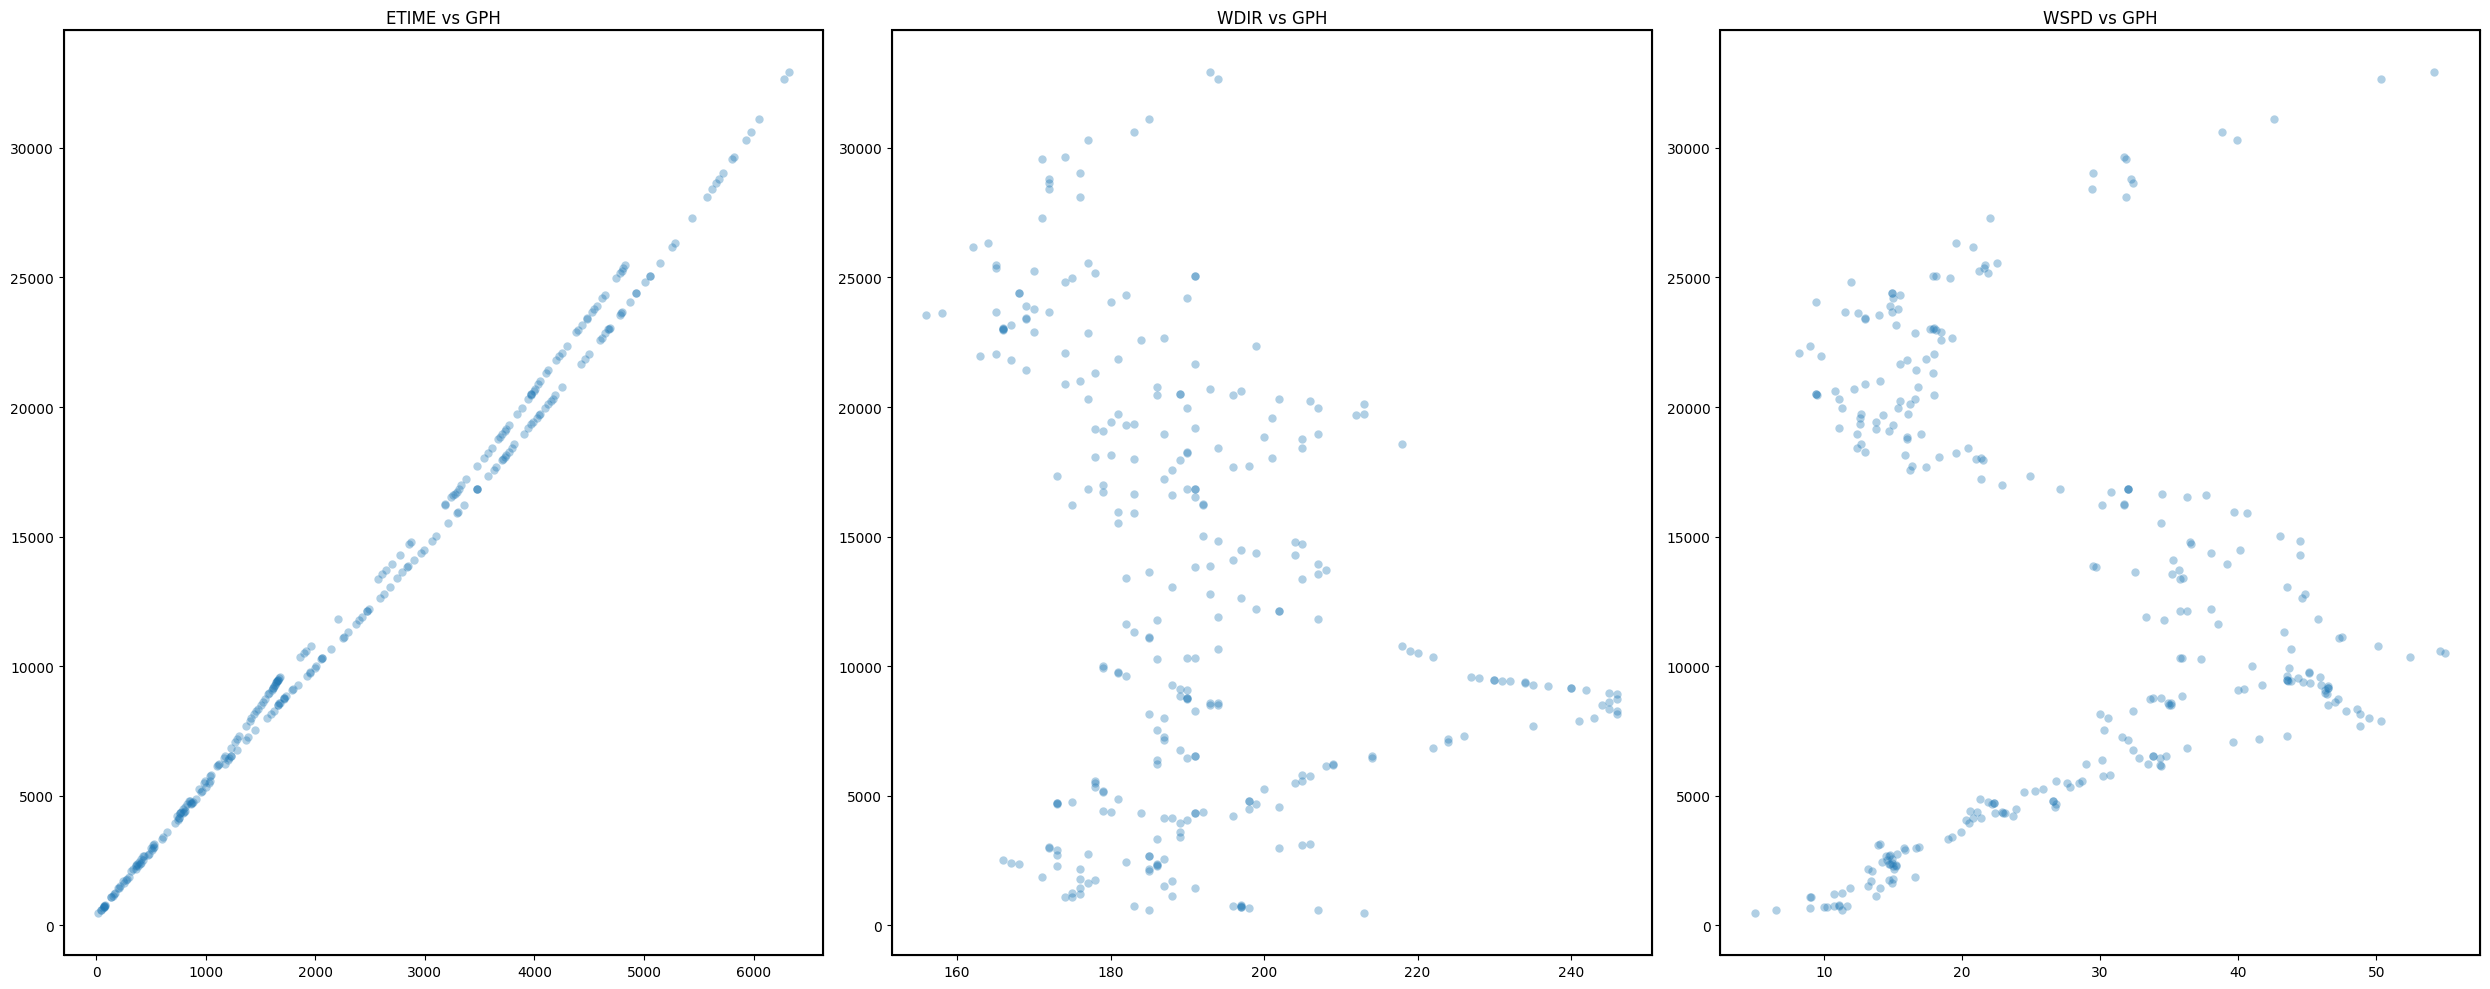

In [9]:
# Function for scatter plot
def scatter_plot(x):
    ax = sns.scatterplot(x=df_20230101[x], y=df['GPH'], alpha=0.35, linewidth=0)
    ax.set_title('{} vs GPH'.format(x), fontsize=12, pad=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(1.5)

features = ['ETIME', 'WDIR', 'WSPD']

plt.figure(figsize=[25, 10])
for i in range(len(features)):
    plt.subplot(1, 3, i + 1)
    scatter_plot(features[i])
plt.tight_layout()
plt.show()

From the scatter plot, it's obivious that wind direction(WDIR) is ramdomly distributed within 230 ~ 300 regardless of height(GPH), while wind speed(WSPD) have 3 different linear relations with height for 3 intervals: 0 ~ 11000(troposphere), 11000 ~ 20000(lower stratosphere), and 20000 ~ 30000(upper stratosphere).    

In [10]:
# Troposphere
interval_1 = (df_20230101['GPH'] >= 0) & (df_20230101['GPH'] <= 11000)
df_z1 = df_20230101[interval_1][['WSPD', 'GPH']]

lm = LinearRegression()

X = df_z1[['GPH']]
y = df_z1['WSPD']
lm.fit(X, y)

coeff_1 = lm.coef_
intercept_1 = lm.intercept_

print("Coefficient:", coeff_1[0])
print("Intercept:", intercept_1)

Coefficient: 0.00402027700780307
Intercept: 5.913388730105552


In [11]:
# Stratosphere
interval_2 = (df_20230101['GPH'] > 11000) & (df_20230101['GPH'] <= 20000)
df_z2 = df_20230101[interval_2][['WSPD', 'GPH']]

lm = LinearRegression()

X = df_z2[['GPH']]
y = df_z2['WSPD']
lm.fit(X, y)

coeff_2 = lm.coef_
intercept_2 = lm.intercept_

print("Coefficient:", coeff_2[0])
print("Intercept:", intercept_2)

Coefficient: -0.0037679727058713766
Intercept: 88.90693733201458


In [12]:
# Mesosphere
interval_3 = (df_20230101['GPH'] > 2000) & (df_20230101['GPH'] <= df_20230101['GPH'].max())
df_z3 = df_20230101[interval_3][['WSPD', 'GPH']]

lm = LinearRegression()

X = df_z3[['GPH']]
y = df_z3['WSPD']
lm.fit(X, y)

coeff_3 = lm.coef_
intercept_3 = lm.intercept_

print("Coefficient:", coeff_3[0])
print("Intercept:", intercept_3)

Coefficient: -0.00035457611234871903
Intercept: 32.413250305365864


# Building the Simulation

## Constants

In [13]:
#-------------------------------------------------------------------------------------
# Physics constants
#-------------------------------------------------------------------------------------
pi = 3.141592654
g = 9.81 #m/s**2
R = 8.3144598 #J/mol.K (Ideal gass constant)
MG = 0.004002602 #kg/mol (Molecular mass of He)
MA = 0.0289644 #kg/mol (Molecular mass of air)

#-------------------------------------------------------------------------------------
# Balloon Constants
#-------------------------------------------------------------------------------------
mP = 5.4 #kg (Mass of payload)
mPB = 1.0 #kg (mass of parachute balloon)
mTB = 2.0 #kg (mass of tractor balloon)
mB = [mPB,mTB]

LP = 15.0 #N (nozzle lift of parachute balloon)
LT = 67.0 #N (nozzle lift of tractor balloon)

## Functions

In [14]:
# Constants
z1    = 11000. #m (boundary of Troposphere)
z2    = 20000. #m (boundary of Stratosphere)
z_max = 30000. #m (Maximum altitude, boundary of Mesosphere)

T0 = 293. #K (air temperature at sea level)
T1 = 217. #K (temperature between lower and upper stratosphere)
dT0 = 6.91e-3 #K/m (temperature gradient in lower stratosphere)
dT1 = 9.20e-4 #K/m (temperature gradient in upper stratosphere)
dT = 2.23e-3 #K/m (temperature gradient over whole atmosphere)
P0 = 101325. #Pa (air pressure at sea level)
P1 = P0*(T0/(T0-dT0*z1))**(-g*MA/(R*dT0)) #Pa (air pressure at 11km)
P2 = P1*exp(-g*MA*(z2-z1)/(R*T1)) #Pa (air pressure at 20km)
Pm = 1112. #Pa (Pressure at z_max)
C3 = 1.11e-14 #1/m^3 (Fit parameter to calculate drag coefficient)
C2 = 2.00e-10 #1/m^2 (Fit parameter to calculate drag coefficient)
C1 = 5.00e-6  #1/m   (Fit parameter to calculate drag coefficient)
C0 = 0.2017   #      (Fit parameter to calculate drag coefficient)

#-------------------------------------------------------------------------------------
# Calculate temperature as a function of altitude
#-------------------------------------------------------------------------------------
def Temperature(z):
    temp = 0.
    if z < z1:
        temp = T0 - dT0*z #troposphere
    elif z < z2:
        temp = T1 #lower stratosphere
    else:
        temp = T1 + dT1*(z-z2) #upper stratosphere
    return temp

#-------------------------------------------------------------------------------------
# Calculate pressure as a function of altitude
#-------------------------------------------------------------------------------------
def Pressure(z):
    pres = 0.
    if z < z1:
        pres = P0*(T0/(T0-dT0*z))**(-g*MA/(R*dT0)) #troposphere
    elif z < z2:
        pres = P1*exp(-g*MA*(z-z1)/(R*T1)) #lower stratosphere
    else:
        pres = P2*(T1/(T1-dT1*(z-z2)))**(-g*MA/(R*dT1)) #upper stratosphere
    return pres

#-------------------------------------------------------------------------------------
# Calculate the drag coefficient as a function of altitude
#-------------------------------------------------------------------------------------
def Cd(z):
    return C3*z**3 + C2*z**2 + C1*z + C0

#-------------------------------------------------------------------------------------
# Calculate the wind speed as a function of altitude
#-------------------------------------------------------------------------------------
def wind(z):
  v_wind = 0
  if z < z1:
    v_wind = coeff_1[0]*z + intercept_1
  elif z < z2:
    v_wind = coeff_2[0]*z + intercept_2
  else:
    v_wind = coeff_3[0]*z + intercept_3
  return v_wind

## Initialize Parameters

In [15]:
#-------------------------------------------------------------------------------------
# Balloon parameters
#-------------------------------------------------------------------------------------
Volume = [0.,0.] #m^3 (Volume of each balloon)
Area   = [0.,0.] #m^2 (Area of each balloon)
mG     = [0.,0.] #kg (Masses of the gas in each balloon)

#-------------------------------------------------------------------------------------
# Gravitational force on the system at sea level
#-------------------------------------------------------------------------------------
Rho_Air = Pressure(0)*MA/(Temperature(0)*R) #kg/m^3 (air density at sea level)
Rho_Gas = Pressure(0)*MG/(Temperature(0)*R) #kg/m^3 (He density at sea level)
mG[0] = (mB[0]+LP/g)/(Rho_Air/Rho_Gas-1) #kg (mass of gas in the parachute balloon)
mG[1] = (mB[1]+LT/g)/(Rho_Air/Rho_Gas-1) #kg (mass of gas in the tractor balloon)
mT = mB[0] + mB[1] + mG[0] + mG[1] + mP #kg (total mass)
F_grav = -mT*g

#-------------------------------------------------------------------------------------
# Buoyancy on the system at sea level
#-------------------------------------------------------------------------------------
Buoyancy = [0.,0.]
Buoyancy[0] = MA*mG[0]*g/MG #N (buoyancy of the parachute balloon)
Buoyancy[1] = MA*mG[1]*g/MG #N (buoyancy of the tractor balloon)

#-------------------------------------------------------------------------------------
# Drag (N)
#-------------------------------------------------------------------------------------
Drag_z = [0.,0.]
Drag_x = [0.,0.]
Drag_y = [0.,0.]

#-------------------------------------------------------------------------------------
# Position x,y,z (m)
#-------------------------------------------------------------------------------------
# Allegheny Observatory is in zone17 in UTM system (84W~78W)
p = Proj(proj='utm',zone= 17,ellps='WGS84', preserve_units=False)

# Allegheny Observatory's coordinate in UTM system
x,y = p(-80.020844,40.482637)
z = 0.

# Positon where last progress is updated (m)
x_last  = 0.
y_last  = 0.
z_last  = 0.

#-------------------------------------------------------------------------------------
# Velocity & Acceleration
#-------------------------------------------------------------------------------------
# Initialize speed (m/s)
vx = 1.0e-9
vy = 1.0e-9
vz = 1.0e-9

# Initialize acceleration (m/s^2)
ax = 0.
ay = 0.
az = 0.

# Average velocity (m/s)
vx_avg = [0.,0.]
vy_avg = [0.,0.]
vz_avg = [0.,0.]

# Average velocity where last progress is updated (m/s)
vx_last = 0.
vy_last = 0.
vz_last = 0.

#-------------------------------------------------------------------------------------
# Time
#-------------------------------------------------------------------------------------
t = 0. # Time
dt = 0.1 # Time step
t_step = 60. # Interval for t_check
t_check = 60. # Threshold for t, record data when t > threshold

#-------------------------------------------------------------------------------------
# Number of points on average
#-------------------------------------------------------------------------------------
nx_avg = [0,0]
ny_avg = [0,0]
nz_avg = [0,0]

We need XY coordinates to To proceed our calculations. However, the location of our launch site -- Allegheny county is given by latitude & longitude. So, we need to translate XY coordinates in to latitude & longitude.

Instead of developing advanced algorithms to perform the task, we utilize the Universal Transverse Mercator(UTM) coordinate system. [https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)

In summary, UTM divides earth into 60 zones, and the point of origin of each UTM zone is the intersection of the equator and the zone's central meridian. To avoid dealing with negative numbers, the central meridian of each zone is defined to coincide with 500000 meters East.

## Motion

In [16]:
# Check status for every 60s
t_check = t_step
trajectory_data = []

# Initialize Wind
WDIR = 213

###############################################################
# Ascent
###############################################################
while z < z_max:

    #-------------------------------------------------------------------------------------
    # Calculate air and gas parameters
    #-------------------------------------------------------------------------------------
    T = Temperature(z) #Temperature of surrounding air
    P = Pressure(z) #Pressure of surrounding air
    Rho_Air = P*MA/(T*R) #Density of the surrounding air
    Rho_Gas = P*MG/(T*R) #Density of the He gas in the balloons
    Volume[0] = mG[0]*R*T/(MG*P) #Volume of the parachute balloon
    Volume[1] = mG[1]*R*T/(MG*P) #Volume of the tractor balloon
    Area[0] = pi*(3*Volume[0]/(4*pi))**(2./3.) #Cross-sectional area of the parachute balloon
    Area[1] = pi*(3*Volume[1]/(4*pi))**(2./3.) #Cross-sectional area of the tractor balloon

    #-------------------------------------------------------------------------------------
    # Calulate the wind
    #-------------------------------------------------------------------------------------
    v_wind = wind(z)
    vx_wind = v_wind*np.cos(np.radians(WDIR))
    vy_wind = v_wind*np.sin(np.radians(WDIR))

    #-------------------------------------------------------------------------------------
    # Calculate the forces and acceleration
    #-------------------------------------------------------------------------------------
    Buoyancy[0] = g*Rho_Air*Volume[0] #Buoyancy force of the parachute balloon
    Buoyancy[1] = g*Rho_Air*Volume[1] #Buoyancy force of the tractor balloon
    C = Cd(z) #Calculate the coefficient of drag

    Drag_x[0] = 0.5*C*Rho_Air*Area[0]*(vx_wind-vx)**2 #parachute
    Drag_x[1] = 0.5*C*Rho_Air*Area[1]*(vx_wind-vx)**2

    Drag_y[0] = 0.5*C*Rho_Air*Area[0]*(vy_wind-vy)**2
    Drag_y[1] = 0.5*C*Rho_Air*Area[1]*(vy_wind-vy)**2

    Drag_z[0] = 0.5*C*Rho_Air*Area[0]*vz**2 #Drag force of the parachute balloon
    Drag_z[1] = 0.5*C*Rho_Air*Area[1]*vz**2 #Drag force of the tractor balloon

    if(vz>0): #If the balloons are moving up then the drag forces will be pointing down.
        Drag_z[0] = -Drag_z[0]
        Drag_z[1] = -Drag_z[1]

    if(vx_wind-vx<0): # If speed of balloon on is smaller than speed of wind on x-direction, the
        Drag_x[0] = -Drag_x[0]
        Drag_x[1] = -Drag_x[1]

    if(vy_wind-vy<0):
        Drag_y[0] = -Drag_y[0]
        Drag_y[1] = -Drag_y[1]

    ax = (Drag_x[0]+Drag_x[1])/mT
    ay = (Drag_y[0]+Drag_y[1])/mT
    az = (Buoyancy[0]+Buoyancy[1]+Drag_z[0]+Drag_z[1]+F_grav)/mT #Acceleration of the system (net-force/mass)

    #-------------------------------------------------------------------------------------
    # Euler method
    #-------------------------------------------------------------------------------------
    vx = vx + ax*dt
    vx_avg[0] += vx
    nx_avg[0] += 1
    x = x + vx*dt

    vy = vy + ay*dt
    vy_avg[0] += vy
    ny_avg[0] += 1
    y = y + vy*dt

    vz = vz + az*dt #Adjust the velocity for the next step
    vz_avg[0] += vz
    nz_avg[0] += 1
    z = z + vz*dt #Adjust the position for the next step

    t += dt #Increment the time step

    #-------------------------------------------------------------------------------------
    # Record the data for every 60s
    #-------------------------------------------------------------------------------------
    if t >= t_check:

      # Calculate the absolute difference between the current z value and all GPH values in actual_data
      closest_index = np.abs(df_20230101['GPH'] - z).idxmin()
      WDIR = df_20230101.loc[closest_index, 'WDIR']

      # Convert x_y to lati_longi
      lons, lats = p(x, y, inverse=True)

      vx_last = (x-x_last)/t_step
      x_last  = x

      vy_last = (y-y_last)/t_step
      y_last  = y

      vz_last = (z-z_last)/t_step
      z_last = z

      # Pack the data into a dictionary
      data_dict = {
                  't': t,
                  'x': x,
                  'y': y,
                  'z': z,

                  'longitude': lons,
                  'latitude': lats,

                  'wind_direction': WDIR,
                  'wind_speed': v_wind,
                  'vx_wind': vx_wind,
                  'vy_wind': vy_wind,

                  'vx_last': vx_last,
                  'vy_last': vy_last,
                  'vz_last': vz_last,

                  'ax': ax,
                  'ay': ay,
                  'az': az,

                  'Volume_0': Volume[0],
                  'Volume_1': Volume[1],
              }

      # Append the data dictionary to the list
      trajectory_data.append(data_dict)

      t_check += t_step

###############################################################
# Descent
###############################################################

# Initialize descent parameters
mB = [mPB,0.0] #kg (mass of the parachute balloon, mass of the tractor balloon = 0)
mG[1] = 0.
mT = mB[0] + mG[0] + mP #kg (total mass, without the tractor balloon)
Weight = -mT*g #Total weight
Buoyancy[0] = MA*mG[0]*g/MG #N (Buoyancy of the balloon)

vz_avg[1] = 0.
nz_avg[1] = 0.

while z >= 0:
    #-------------------------------------------------------------------------------------
    # Calculate air and gas parameters
    #-------------------------------------------------------------------------------------
    T = Temperature(z) #Temperature of surrounding air
    P = Pressure(z) #Pressure of surrounding air
    Rho_Air = P*MA/(T*R) #Density of the surrounding air
    Rho_Gas = P*MG/(T*R) #Density of the He gas in the balloon
    Volume[0] = mG[0]*R*T/(MG*P) #Volume of the parachute balloon
    Area[0] = pi*(3*Volume[0]/(4*pi))**(2./3.) #Cross-sectional area of the parachute balloon

    #-------------------------------------------------------------------------------------
    # Calulate the wind
    #-------------------------------------------------------------------------------------
    v_wind = wind(z)
    vx_wind = v_wind*np.cos(np.radians(WDIR))
    vy_wind = v_wind*np.sin(np.radians(WDIR))

    #-------------------------------------------------------------------------------------
    # Calculate the forces and acceleration
    #-------------------------------------------------------------------------------------
    Buoyancy[0] = g*Rho_Air*Volume[0] #Buoyancy force of the parachute balloon
    C = Cd(z) #Calculate the coefficient of drag

    Drag_x[0] = 0.5*C*Rho_Air*Area[0]*(vx_wind-vx)**2
    Drag_y[0] = 0.5*C*Rho_Air*Area[0]*(vy_wind-vy)**2
    Drag_z[0] = 0.5*C*Rho_Air*Area[0]*vz**2 #Drag force of the parachute balloon

    if(vz>0): #If the balloon is moving up then the drag force will be pointing down.
        Drag_z[0] = -Drag_z[0]

    if(vx_wind-vx<0):
        Drag_x[0] = -Drag_x[0]

    if(vy_wind-vy<0):
        Drag_y[0] = -Drag_y[0]


    ax = Drag_x[0]/mT
    ay = Drag_y[0]/mT
    az = (Buoyancy[0]+Drag_z[0]+Weight)/mT #Acceleration of the system (net-force/mass)

    #-------------------------------------------------------------------------------------
    # Euler method
    #-------------------------------------------------------------------------------------
    vx = vx + ax*dt
    vx_avg[1] += vx
    nx_avg[1] += 1
    x = x + vx*dt

    vy = vy + ay*dt
    vy_avg[1] += vy
    ny_avg[1] += 1
    y = y + vy*dt

    vz = vz + az*dt #adjust the velocity for the next step
    vz_avg[1]+=vz
    nz_avg[1]+=1
    z = z + vz*dt #adjust the position for the next step

    t += dt #increment the time step

    #-------------------------------------------------------------------------------------
    # Record the data for every 60s
    #-------------------------------------------------------------------------------------
    if t >= t_check:

      # Calculate the absolute difference between the current z value and all GPH values in actual_data
      closest_index = np.abs(df_20230101['GPH'] - z).idxmin()
      WDIR = df_20230101.loc[closest_index, 'WDIR']

      # Convert x_y to lati_longi
      lons, lats = p(x, y, inverse=True)

      vx_last = (x-x_last)/t_step
      x_last  = x


      vy_last = (y-y_last)/t_step
      y_last  = y


      vz_last = (z-z_last)/t_step
      z_last = z

      # Pack the data into a dictionary
      data_dict = {
                  't': t,
                  'x': x,
                  'y': y,
                  'z': z,

                  'longitude': lons,
                  'latitude': lats,

                  'wind_direction': WDIR,
                  'wind_speed': v_wind,
                  'vx_wind': vx_wind,
                  'vy_wind': vy_wind,

                  'vx_last': vx_last,
                  'vy_last': vy_last,
                  'vz_last': vz_last,

                  'ax': ax,
                  'ay': ay,
                  'az': az,

                  'Volume_0': Volume[0],
                  'Volume_1': Volume[1],
              }


      # Append the data dictionary to the list
      trajectory_data.append(data_dict)

      t_check += t_step

trajectory_df = pd.DataFrame(trajectory_data)

In [17]:
#show all columns & rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.6f}'.format)

trajectory_df

,t,x,y,z,longitude,latitude,wind_direction,wind_speed,vx_wind,vy_wind,vx_last,vy_last,vz_last,ax,ay,az,Volume_0,Volume_1
0,60.000000,582706.762572,4481613.290027,337.558309,-80.024204,40.481093,213.000000,7.268153,-6.095586,-3.958520,9711.779376,74693.554834,5.625972,-0.019865,-0.013369,0.000100,2.513851,8.776693
1,120.100000,582333.861080,4481375.725045,683.659649,-80.028634,40.478990,198.000000,8.659574,-7.262529,-4.716342,-6.215025,-3.959416,5.768356,-0.019418,-0.012620,0.000096,2.597147,9.067508
2,180.100000,581837.857617,4481181.892140,1029.529289,-80.034510,40.477293,175.000000,10.050063,-9.558178,-3.105640,-8.266724,-3.230548,5.764494,-0.022268,-0.000056,0.000091,2.683872,9.370295
3,240.100000,581230.677266,4481201.491405,1375.727412,-80.041670,40.477529,191.000000,11.441873,-11.398333,0.997225,-10.119673,0.326654,5.769969,-0.023240,0.004365,0.000087,2.774346,9.686170
4,300.100000,580544.624094,4481097.607031,1722.237491,-80.049776,40.476660,188.000000,12.834938,-12.599124,-2.449022,-11.434220,-1.731406,5.775168,-0.022706,-0.006168,0.000082,2.868763,10.015810
5,360.000000,579774.112165,4480975.341297,2068.463711,-80.058880,40.475633,185.000000,14.226861,-14.088406,-1.979996,-12.841865,-2.037762,5.770437,-0.023053,0.000045,0.000077,2.967160,10.359346
6,420.000000,578914.077943,4480880.437533,2415.543586,-80.069037,40.474861,167.000000,15.622217,-15.562769,-1.361566,-14.333904,-1.581729,5.784665,-0.023199,0.000882,0.000071,3.070082,10.718683
7,480.000000,577986.226338,4481059.616452,2762.879958,-80.079960,40.476562,177.000000,17.018603,-16.582418,3.828353,-15.464193,2.986315,5.788940,-0.022454,0.006969,0.000066,3.177601,11.094066
8,540.000000,576959.683724,4481145.651803,3110.452668,-80.092058,40.477433,205.000000,18.415940,-18.390702,0.963816,-17.109044,1.433923,5.792879,-0.023381,-0.002054,0.000060,3.289959,11.486346
9,600.000000,575917.863757,4480710.618065,3458.240886,-80.104400,40.473610,189.000000,19.814144,-17.957713,-8.373819,-17.363666,-7.250562,5.796470,-0.016301,-0.011036,0.000054,3.407417,11.896430


In [18]:
# Check if the balloon has crossed into neighboring zones
# UTM boundaries
utm_x_min = 166021.4431
utm_x_max = 833978.5569

x_final = trajectory_df['x'].iloc[-1]

x_final < utm_x_min or x_final > utm_x_max

False